# Motif discovery

This notebook extracts motifs from the CNN model and estimates their contributions.

The process is roughy divided as follows:

1) Convolutional filter motif extraction: for
each of the 128 convolutional filters in the second convolutional layer (first convolutional
block, before the max pooling layer), we accumulated the 100 sequence fragments (seqlets)
that resulted in maximal filter activation across all MPRA sequences, and used them to
generate a filter position weight matrix (PWM). . This process resulted in 1280 filter motifs (128 motifs per
model x 10 models).

2) Motif clustering: to account for motif redundancy within and across
models, PWMs were clustered using a standalone version of RSAT matrix clustering (Castro-
Mondragon et al, 2017) (https://github.com/jaimicore/matrix-clustering_stand-alone),
modified by us to remove the ability to use PWM reverse complements. To improve clustering
results, we first separated motifs that contained AUGs from the rest and clustered these sets separately with different normalized correlation
thresholds but otherwise identical parameters. This resulted in 25 AUG and 573 non-AUG motif clusters.

3) Motif filtering and post-processing: Reproducible and robust motifs should emerge independently in models trained on different data splits. Thus, motif clusters were required to contain motif filters originating
from multiple individual models (10 for AUG motifs, 5 or more for non-AUG motifs), and those
that did not were discarded. This resulted in 5 and 11 AUG and non-AUG motifs, respectively.

4) Motif contribution score calculation: Motif cluster PWMs were scanned against all MPRA sequences with
contribution scores using FIMO. For each match in each motif, contribution scores were summed across all matching bases and averaged across all matches to obtain the motif contribution scores.

In [1]:
import gc
import json
import os
import pickle
import random
import re
import sys

import numpy
import matplotlib
from matplotlib import pyplot
import pandas
import seaborn

import tensorflow
from tensorflow.keras import layers, models

import Bio
import Bio.motifs
import Bio.motifs.transfac
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

utils_dir = '../utils'
sys.path.append(utils_dir)
import seq_utils
import cnn_vgg
import custom_plots

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Arial'

In [3]:
# Code related to saving meme files

meme_header = f"""MEME version 4

ALPHABET= ACGU

strands: +

Background letter frequencies
A 0.25 C 0.25 G 0.25 U 0.25

"""

def save_meme_from_dict(meme_dict, filepath):
    meme_full_str = meme_header

    for motif_id, motif_info in meme_dict.items():

        meme_motif_full_str = ''
        meme_motif_full_str += f"MOTIF {motif_id} {motif_info['name']}\n"
        meme_motif_full_str += f"letter-probability matrix: alength= 4 w= {len(motif_info['ppm'])} nsites= {motif_info['nsites']}\n"
        for pwm_row in motif_info['ppm']:
            for pwm_val in pwm_row:
                meme_motif_full_str += f'{pwm_val:.6f} '
            meme_motif_full_str += '\n'
        meme_full_str += meme_motif_full_str + '\n'

    with open(filepath, 'w') as file: 
        file.write(meme_full_str)


In [4]:
# Create directory for results
base_results_dir = 'results'
if not os.path.exists(base_results_dir):
    os.mkdir(base_results_dir)

# Load data

In [5]:
# Relevant column names
tpm_fraction_list = ['input', '80S', 'LMW', 'HMW']
pol_fraction_list = ['80S', 'LMW', 'HMW']
timepoint_list = [2, 4, 6, 10]

min_input_tpm_col = 'min_TPM_input'

# Input TPM columns
input_tpm_cols = [f'gmean_TPM_input_{t}hpf' for t in timepoint_list]
input_log2_tpm_cols = [f'log2_TPM_input_{t}hpf' for t in timepoint_list]
diff_log2_tpm_input_cols = [f'diff_log2_TPM_input_{t}-2hpf' for t in timepoint_list[1:]]

# MRL columns
mrl_cols = [f'MRL_{t}hpf' for t in timepoint_list]
log2_mrl_cols = [f'log2_MRL_{t}hpf' for t in timepoint_list]

# Model preditions
pred_len_cols = [f'pred_len_{c}' for c in log2_mrl_cols + diff_log2_tpm_input_cols]
pred_cnn_cols = [f'pred_cnn_ens_{c}' for c in log2_mrl_cols + diff_log2_tpm_input_cols]
pred_full_cols = [f'pred_full_{c}' for c in log2_mrl_cols + diff_log2_tpm_input_cols]

# Residuals
res_log2_mrl_cols = [f'res_{c}' for c in log2_mrl_cols]
res_diff_log2_tpm_input_cols = [f'res_{c}' for c in diff_log2_tpm_input_cols]
res_cols = res_log2_mrl_cols + res_diff_log2_tpm_input_cols

In [6]:
# Load data

# Load measurements
data_full = pandas.read_csv(
    '../00_data/Zb_5UTR_MPRA_TPM_MRL.tsv.gz',
    index_col=0,
    sep='\t',
)
# Load length model residuals
data_res = pandas.read_csv(
    '../01_length_model/Zb_5UTR_MPRA_len_residuals.tsv.gz',
    index_col=0,
    sep='\t',
)
# Load precomputed model predictions
data_preds = pandas.read_csv(
    '../03_full_model_evaluation/Zb_5UTR_MPRA_TPM_MRL_full_predictions.tsv.gz',
    index_col=0,
    sep='\t',
)
# Check if there are duplicate columns in data_preds
duplicate_cols = [c for c in data_preds.columns if c in data_full.columns]
data_preds = data_preds.drop(columns=duplicate_cols)

data_full = pandas.concat([data_full, data_res, data_preds], axis=1)
data_full

,chr,strand,external_gene_name,utr_length,insert_length,n_uORFs,GC_content,mxfold,index,index_base,...,pred_cnn_ens_diff_log2_TPM_input_4-2hpf,pred_cnn_ens_diff_log2_TPM_input_6-2hpf,pred_cnn_ens_diff_log2_TPM_input_10-2hpf,pred_full_log2_MRL_2hpf,pred_full_log2_MRL_4hpf,pred_full_log2_MRL_6hpf,pred_full_log2_MRL_10hpf,pred_full_diff_log2_TPM_input_4-2hpf,pred_full_diff_log2_TPM_input_6-2hpf,pred_full_diff_log2_TPM_input_10-2hpf
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,chr9,-,slc35a5,103,103,2,52.427184,23.9,20318.0,20318,...,-0.078608,-0.275502,-0.817384,2.549829,2.884137,2.643531,2.604016,-0.103411,-0.036273,-0.907648
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,chr4,-,nrf1,134,134,0,61.940299,35.3,72681.0,72681,...,-0.129356,-0.111522,-0.078279,2.518904,2.840914,2.935248,2.455554,-0.023481,-0.075414,-0.021104
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,chr4,+,ube2h,178,178,1,46.629213,30.1,27446.0,27446,...,-0.009150,0.081602,0.160492,3.092140,3.124510,3.332553,2.346480,0.112489,-0.162220,0.229684
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,chr12,+,slc9a3r1a,152,152,0,46.052632,26.1,113092.0,113092,...,0.009686,0.142486,0.467795,3.539392,3.280586,3.423845,2.765956,0.146078,0.062890,0.557860
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,chr24,-,dap,153,153,1,47.058824,31.8,20320.0,20320,...,-0.028025,0.053350,0.120577,2.678368,2.925368,3.047901,2.336356,0.109086,-0.032626,0.211333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000025554_ENSDART00000103273_1746_wdr83os_27060,chr11,+,wdr83os,126,126,1,37.301587,22.8,27060.0,27060,...,0.108482,0.176995,0.310650,3.591318,3.433469,3.388342,2.948345,0.190096,0.265055,0.340774
ENSDARG00000103318_ENSDART00000161570_7325_mrpl3_86762,chr19,+,mrpl3,111,111,2,34.234234,12.5,86762.0,86762,...,0.193845,0.165420,0.060420,3.733998,3.697353,3.571290,3.384255,0.212228,0.351765,0.019203
ENSDARG00000036698_ENSDART00000053300_7697_znf865_21263.6,chr19,-,znf865,1305,197,4,31.979695,25.9,21263.6,21263,...,0.022883,-0.049307,-0.125676,2.579257,2.528403,2.627737,1.175040,0.089769,-0.410971,-0.122842
ENSDARG00000056892_ENSDART00000148517_5556_mpp6a_23746.2,chr16,-,mpp6a,311,161,1,39.130435,37.6,23746.2,23746,...,0.077057,0.324958,0.694782,3.498435,3.283032,3.421283,2.649789,0.216211,0.188127,0.786767


In [7]:
# Preserve only rows with input tpm above threshold
tpm_threshold = 2
data = data_full[data_full[min_input_tpm_col] > tpm_threshold]
data

,chr,strand,external_gene_name,utr_length,insert_length,n_uORFs,GC_content,mxfold,index,index_base,...,pred_cnn_ens_diff_log2_TPM_input_4-2hpf,pred_cnn_ens_diff_log2_TPM_input_6-2hpf,pred_cnn_ens_diff_log2_TPM_input_10-2hpf,pred_full_log2_MRL_2hpf,pred_full_log2_MRL_4hpf,pred_full_log2_MRL_6hpf,pred_full_log2_MRL_10hpf,pred_full_diff_log2_TPM_input_4-2hpf,pred_full_diff_log2_TPM_input_6-2hpf,pred_full_diff_log2_TPM_input_10-2hpf
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,chr9,-,slc35a5,103,103,2,52.427184,23.9,20318.0,20318,...,-0.078608,-0.275502,-0.817384,2.549829,2.884137,2.643531,2.604016,-0.103411,-0.036273,-0.907648
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,chr4,-,nrf1,134,134,0,61.940299,35.3,72681.0,72681,...,-0.129356,-0.111522,-0.078279,2.518904,2.840914,2.935248,2.455554,-0.023481,-0.075414,-0.021104
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,chr4,+,ube2h,178,178,1,46.629213,30.1,27446.0,27446,...,-0.009150,0.081602,0.160492,3.092140,3.124510,3.332553,2.346480,0.112489,-0.162220,0.229684
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,chr12,+,slc9a3r1a,152,152,0,46.052632,26.1,113092.0,113092,...,0.009686,0.142486,0.467795,3.539392,3.280586,3.423845,2.765956,0.146078,0.062890,0.557860
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,chr24,-,dap,153,153,1,47.058824,31.8,20320.0,20320,...,-0.028025,0.053350,0.120577,2.678368,2.925368,3.047901,2.336356,0.109086,-0.032626,0.211333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000005482_ENSDART00000169300_4321_rapgef2_17462.3,chr14,-,rapgef2,478,164,0,53.048780,45.5,17462.3,17462,...,-0.161651,-0.087354,0.112831,2.420593,2.809052,3.135890,2.488409,-0.023428,-0.243173,0.203304
ENSDARG00000037178_ENSDART00000054066_201_zic2b_19629.1,chr1,+,zic2b,281,145,1,40.689655,16.4,19629.1,19629,...,0.077898,0.147831,0.231401,3.416857,3.258459,3.349173,2.588786,0.206383,0.113036,0.313278
ENSDARG00000037178_ENSDART00000054066_201_zic2b_19629.2,chr1,+,zic2b,281,146,1,39.726027,19.3,19629.2,19629,...,0.123626,0.234874,0.488536,3.474302,3.230998,3.322496,2.671402,0.253548,0.193664,0.571941
ENSDARG00000101903_ENSDART00000168627_8580_zfyve9a_20081.1,chr2,-,zfyve9a,304,156,3,41.666667,22.9,20081.1,20081,...,0.071421,0.070987,0.025346,2.825407,2.760289,2.919384,2.008327,0.210069,-0.034097,0.117460


In [8]:
# Max sequence length
# Needed for one hot encoding and other calculations
max_seq_len = data_full['insert_length'].max()
max_seq_len

238

In [9]:
# Load contribution scores
# Dictionary, where keys are insert ids and values are numpy arrays
# with dimensions (n_model_outputs, max_seq_len, 4)

with open('../04_interpretation/contributions_ensemble_cnn_model.pickle', 'rb') as handle:
    contributions_dict = pickle.load(handle)
assert set(data.index.to_list()) == set(contributions_dict.keys())
print(f"Contribution scores for {len(contributions_dict):,} sequences loaded.")

Contribution scores for 17,879 sequences loaded.


In [10]:
# Construct contributions array
contributions_array = numpy.array([contributions_dict[index] for index in data.index])
display(contributions_array.shape)

(17879, 7, 238, 4)

# Step 1: Extracting PWMs from the convolutional layers of the models

PWMs are calculated as follows:
- Reduced models containing only the first two layers of each CNN model are created. The input of these models is one-hot encoded sequences as before, but the `(n_seqs, n_positions, n_filters)` output contains a "score" for each position in every sequence and every filter.
- Filter scores are calculated on every MPRA sequence by predicting with these models.
- For each filter, a threshold score is set to retain the top 100 score values, and the seqlets (sequence fragments) that produced these are accumulated.
- A PWM is generated from these seqlets.

In addition, this section generates plots for each filter, containing the following:
- Histogram of filter scores along with threshold
- PWM logo
- Bar plot with average contribution of each output, taken from the previously calculated SHAP contribution scores.

Each model has a directory createdd, where plots and a `motifs.meme` file with all extracted PWMs are stored.

Finally, a single `motif.meme` file with all filters from all models is created to be used in later steps.

In [11]:
# Settings: which convolutional layer to extract PWMs from

# last_layer = 1
# receptive_field = 7
# n_seqlets_per_filter = 1000

last_layer = 2
receptive_field = 13
n_seqlets_per_filter = 100

# Create directory to store results with these settings
analysis_dir = os.path.join(base_results_dir, f'last_layer_{last_layer}_n_{n_seqlets_per_filter}')
if not os.path.exists(analysis_dir):
    os.mkdir(analysis_dir)

In [12]:
# Create directory for filter extraction results
filter_ext_dir = os.path.join(analysis_dir, f'filters')
if not os.path.exists(filter_ext_dir):
    os.mkdir(filter_ext_dir)

In [13]:
# One-hot encode sequences
seqs_one_hot = seq_utils.one_hot_encode(
    data['insert_seq'].values,
    max_seq_len=max_seq_len,
    padding='right',
    mask_val=0,
)

In [14]:
# Make reduced models
reduced_models = []
for model_idx in range(10):
    # Load model
    model_path = os.path.join('../02_cnn/models_cnn_vgg', f'model_{model_idx:03d}.h5')
    model = cnn_vgg.load_model(model_path)

    # Make reduced model
    reduced_model = tensorflow.keras.Model(
        inputs=model.input,
        outputs=model.layers[last_layer].output,
    )
    reduced_models.append(reduced_model)

In [15]:
# Code to make an extended set of model outputs for plotting,
# containing the differences in MRL and input TPM between timepoints
def make_extended_output(val):
    val_extended = numpy.array([
            val[:, 0],
            val[:, 1],
            val[:, 2],
            val[:, 3],
            val[:, 1] - val[:, 0],
            val[:, 2] - val[:, 0],
            val[:, 3] - val[:, 0],
            val[:, 2] - val[:, 1],
            val[:, 3] - val[:, 1],
            val[:, 3] - val[:, 2],
            val[:, 4],
            val[:, 5],
            val[:, 6],
            val[:, 5] - val[:, 4],
            val[:, 6] - val[:, 4],
            val[:, 6] - val[:, 5],
        ])
    return val_extended

model_outputs_ext_labels = [
    'log2_MRL_2hpf',
    'log2_MRL_4hpf',
    'log2_MRL_6hpf',
    'log2_MRL_10hpf',
    'Δlog2_MRL_4-2hpf',
    'Δlog2_MRL_6-2hpf',
    'Δlog2_MRL_10-2hpf',
    'Δlog2_MRL_6-4hpf',
    'Δlog2_MRL_10-4hpf',
    'Δlog2_MRL_10-6hpf',
    'Δlog2_TPM_input_4-2hpf',
    'Δlog2_TPM_input_6-2hpf',
    'Δlog2_TPM_input_10-2hpf',
    'Δlog2_TPM_input_6-4hpf',
    'Δlog2_TPM_input_10-4hpf',
    'Δlog2_TPM_input_10-6hpf',
]

Processing model 0...
Filter 0 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 1 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 2 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 3 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 4 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 5 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 6 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 7 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 8 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 9 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 10 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 11 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 12 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 13 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 14 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 15 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 16 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 17 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 18 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 19 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 20 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 21 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 22 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 23 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 24 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 25 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 26 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 27 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 28 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 29 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 30 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 31 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 32 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 33 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 34 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 35 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 36 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 37 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 38 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 39 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 40 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 41 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 42 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 43 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 44 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 45 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 46 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 47 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 48 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 49 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 50 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 51 / 128...
Filter 52 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 53 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 54 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 55 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 56 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 57 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 58 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 59 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 60 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 61 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 62 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 63 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 64 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 65 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 66 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 67 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 68 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 69 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 70 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 71 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 72 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 73 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 74 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 75 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 76 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 77 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 78 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 79 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 80 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 81 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 82 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 83 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 84 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 85 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 86 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 87 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 88 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 89 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 90 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 91 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 92 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 93 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 94 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 95 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 96 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 97 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 98 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 99 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 100 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 101 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 102 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 103 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 104 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 105 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 106 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 107 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 108 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 109 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 110 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 111 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 112 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 113 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 114 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 115 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 116 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 117 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 118 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 119 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 120 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 121 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 122 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 123 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 124 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 125 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 126 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 127 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Saving meme file...
Done with model 0.
Processing model 1...
Filter 0 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 1 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 2 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 3 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 4 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 5 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 6 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 7 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 8 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 9 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 10 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 11 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 12 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 13 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 14 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 15 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 16 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 17 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 18 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 19 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 20 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 21 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 22 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 23 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 24 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 25 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 26 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 27 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 28 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 29 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 30 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 31 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 32 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 33 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 34 / 128...
Filter 35 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 36 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 37 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 38 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 39 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 40 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 41 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 42 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 43 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 44 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 45 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 46 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 47 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 48 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 49 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 50 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 51 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 52 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 53 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 54 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 55 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 56 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 57 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 58 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 59 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 60 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 61 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 62 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 63 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 64 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 65 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 66 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 67 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 68 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 69 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 70 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 71 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 72 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 73 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 74 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 75 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 76 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 77 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 78 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 79 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 80 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 81 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 82 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 83 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 84 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 85 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 86 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 87 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 88 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 89 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 90 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 91 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 92 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 93 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 94 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 95 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 96 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 97 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 98 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 99 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 100 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 101 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 102 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 103 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 104 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 105 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 106 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 107 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 108 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 109 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 110 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 111 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 112 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 113 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 114 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 115 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 116 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 117 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 118 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 119 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 120 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 121 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 122 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 123 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 124 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 125 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 126 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 127 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Saving meme file...
Done with model 1.
Processing model 2...
Filter 0 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 1 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 2 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 3 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 4 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 5 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 6 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 7 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 8 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 9 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 10 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 11 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 12 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 13 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 14 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 15 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 16 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 17 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 18 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 19 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 20 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 21 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 22 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 23 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 24 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 25 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 26 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 27 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 28 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 29 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 30 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 31 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 32 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 33 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 34 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 35 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 36 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 37 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 38 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 39 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 40 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 41 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 42 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 43 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 44 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 45 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 46 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 47 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 48 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 49 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 50 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 51 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 52 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 53 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 54 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 55 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 56 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 57 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 58 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 59 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 60 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 61 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 62 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 63 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 64 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 65 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 66 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 67 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 68 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 69 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 70 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 71 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 72 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 73 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 74 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 75 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 76 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 77 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 78 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 79 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 80 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 81 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 82 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 83 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 84 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 85 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 86 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 87 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 88 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 89 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 90 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 91 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 92 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 93 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 94 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 95 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 96 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 97 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 98 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 99 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 100 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 101 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 102 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 103 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 104 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 105 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 106 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 107 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 108 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 109 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 110 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 111 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 112 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 113 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 114 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 115 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 116 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 117 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 118 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 119 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 120 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 121 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 122 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 123 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 124 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 125 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 126 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 127 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Saving meme file...
Done with model 2.
Processing model 3...
Filter 0 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 1 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 2 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 3 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 4 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 5 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 6 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 7 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 8 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 9 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 10 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 11 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 12 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 13 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 14 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 15 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 16 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 17 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 18 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 19 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 20 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 21 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 22 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 23 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 24 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 25 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 26 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 27 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 28 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 29 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 30 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 31 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 32 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 33 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 34 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 35 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 36 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 37 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 38 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 39 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 40 / 128...
Filter 41 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 42 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 43 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 44 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 45 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 46 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 47 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 48 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 49 / 128...
Filter 50 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 51 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 52 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 53 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 54 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 55 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 56 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 57 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 58 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 59 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 60 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 61 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 62 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 63 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 64 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 65 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 66 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 67 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 68 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 69 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 70 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 71 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 72 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 73 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 74 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 75 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 76 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 77 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 78 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 79 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 80 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 81 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 82 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 83 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 84 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 85 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 86 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 87 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 88 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 89 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 90 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 91 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 92 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 93 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 94 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 95 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 96 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 97 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 98 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 99 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 100 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 101 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 102 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 103 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 104 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 105 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 106 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 107 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 108 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 109 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 110 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 111 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 112 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 113 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 114 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 115 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 116 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 117 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 118 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 119 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 120 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 121 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 122 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 123 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 124 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 125 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 126 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 127 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Saving meme file...
Done with model 3.
Processing model 4...
Filter 0 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 1 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 2 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 3 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 4 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 5 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 6 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 7 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 8 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 9 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 10 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 11 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 12 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 13 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 14 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 15 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 16 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 17 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 18 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 19 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 20 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 21 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 22 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 23 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 24 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 25 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 26 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 27 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 28 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 29 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 30 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 31 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 32 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 33 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 34 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 35 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 36 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 37 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 38 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 39 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 40 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 41 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 42 / 128...
Filter 43 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 44 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 45 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 46 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 47 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 48 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 49 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 50 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 51 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 52 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 53 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 54 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 55 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 56 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 57 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 58 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 59 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 60 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 61 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 62 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 63 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 64 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 65 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 66 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 67 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 68 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 69 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 70 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 71 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 72 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 73 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 74 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 75 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 76 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 77 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 78 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 79 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 80 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 81 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 82 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 83 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 84 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 85 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 86 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 87 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 88 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 89 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 90 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 91 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 92 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 93 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 94 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 95 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 96 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 97 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 98 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 99 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 100 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 101 / 128...
Filter 102 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 103 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 104 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 105 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 106 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 107 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 108 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 109 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 110 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 111 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 112 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 113 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 114 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 115 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 116 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 117 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 118 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 119 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 120 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 121 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 122 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 123 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 124 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 125 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 126 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 127 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Saving meme file...
Done with model 4.
Processing model 5...
Filter 0 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 1 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 2 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 3 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 4 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 5 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 6 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 7 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 8 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 9 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 10 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 11 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 12 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 13 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 14 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 15 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 16 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 17 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 18 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 19 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 20 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 21 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 22 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 23 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 24 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 25 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 26 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 27 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 28 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 29 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 30 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 31 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 32 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 33 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 34 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 35 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 36 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 37 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 38 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 39 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 40 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 41 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 42 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 43 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 44 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 45 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 46 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 47 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 48 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 49 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 50 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 51 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 52 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 53 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 54 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 55 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 56 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 57 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 58 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 59 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 60 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 61 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 62 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 63 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 64 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 65 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 66 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 67 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 68 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 69 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 70 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 71 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 72 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 73 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 74 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 75 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 76 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 77 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 78 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 79 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 80 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 81 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 82 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 83 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 84 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 85 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 86 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 87 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 88 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 89 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 90 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 91 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 92 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 93 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 94 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 95 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 96 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 97 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 98 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 99 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 100 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 101 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 102 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 103 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 104 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 105 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 106 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 107 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 108 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 109 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 110 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 111 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 112 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 113 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 114 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 115 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 116 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 117 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 118 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 119 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 120 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 121 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 122 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 123 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 124 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 125 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 126 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 127 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Saving meme file...
Done with model 5.
Processing model 6...
Filter 0 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 1 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 2 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 3 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 4 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 5 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 6 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 7 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 8 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 9 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 10 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 11 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 12 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 13 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 14 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 15 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 16 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 17 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 18 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 19 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 20 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 21 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 22 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 23 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 24 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 25 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 26 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 27 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 28 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 29 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 30 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 31 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 32 / 128...
Filter 33 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 34 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 35 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 36 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 37 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 38 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 39 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 40 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 41 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 42 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 43 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 44 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 45 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 46 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 47 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 48 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 49 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 50 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 51 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 52 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 53 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 54 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 55 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 56 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 57 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 58 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 59 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 60 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 61 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 62 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 63 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 64 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 65 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 66 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 67 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 68 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 69 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 70 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 71 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 72 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 73 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 74 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 75 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 76 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 77 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 78 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 79 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 80 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 81 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 82 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 83 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 84 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 85 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 86 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 87 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 88 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 89 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 90 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 91 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 92 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 93 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 94 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 95 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 96 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 97 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 98 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 99 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 100 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 101 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 102 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 103 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 104 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 105 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 106 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 107 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 108 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 109 / 128...
Filter 110 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 111 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 112 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 113 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 114 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 115 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 116 / 128...
Filter 117 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 118 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 119 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 120 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 121 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 122 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 123 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 124 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 125 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 126 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 127 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Saving meme file...
Done with model 6.
Processing model 7...
Filter 0 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 1 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 2 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 3 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 4 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 5 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 6 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 7 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 8 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 9 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 10 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 11 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 12 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 13 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 14 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 15 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 16 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 17 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 18 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 19 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 20 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 21 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 22 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 23 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 24 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 25 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 26 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 27 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 28 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 29 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 30 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 31 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 32 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 33 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 34 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 35 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 36 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 37 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 38 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 39 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 40 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 41 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 42 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 43 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 44 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 45 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 46 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 47 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 48 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 49 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 50 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 51 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 52 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 53 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 54 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 55 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 56 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 57 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 58 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 59 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 60 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 61 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 62 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 63 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 64 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 65 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 66 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 67 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 68 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 69 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 70 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 71 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 72 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 73 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 74 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 75 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 76 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 77 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 78 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 79 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 80 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 81 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 82 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 83 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 84 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 85 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 86 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 87 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 88 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 89 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 90 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 91 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 92 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 93 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 94 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 95 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 96 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 97 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 98 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 99 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 100 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 101 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 102 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 103 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 104 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 105 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 106 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 107 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 108 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 109 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 110 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 111 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 112 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 113 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 114 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 115 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 116 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 117 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 118 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 119 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 120 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 121 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 122 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 123 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 124 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 125 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 126 / 128...
Filter 127 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Saving meme file...
Done with model 7.
Processing model 8...
Filter 0 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 1 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 2 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 3 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 4 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 5 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 6 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 7 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 8 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 9 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 10 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 11 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 12 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 13 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 14 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 15 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 16 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 17 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 18 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 19 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 20 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 21 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 22 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 23 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 24 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 25 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 26 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 27 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 28 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 29 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 30 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 31 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 32 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 33 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 34 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 35 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 36 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 37 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 38 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 39 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 40 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 41 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 42 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 43 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 44 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 45 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 46 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 47 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 48 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 49 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 50 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 51 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 52 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 53 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 54 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 55 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 56 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 57 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 58 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 59 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 60 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 61 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 62 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 63 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 64 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 65 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 66 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 67 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 68 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 69 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 70 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 71 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 72 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 73 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 74 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 75 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 76 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 77 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 78 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 79 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 80 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 81 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 82 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 83 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 84 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 85 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 86 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 87 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 88 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 89 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 90 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 91 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 92 / 128...
Filter 93 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 94 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 95 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 96 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 97 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 98 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 99 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 100 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 101 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 102 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 103 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 104 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 105 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 106 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 107 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 108 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 109 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 110 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 111 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 112 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 113 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 114 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 115 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 116 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 117 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 118 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 119 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 120 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 121 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 122 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 123 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 124 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 125 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 126 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 127 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Saving meme file...
Done with model 8.
Processing model 9...
Filter 0 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 1 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 2 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 3 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 4 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 5 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 6 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 7 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 8 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 9 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 10 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 11 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 12 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 13 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 14 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 15 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 16 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 17 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 18 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 19 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 20 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 21 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 22 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 23 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 24 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 25 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 26 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 27 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 28 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 29 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 30 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 31 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 32 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 33 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 34 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 35 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 36 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 37 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 38 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 39 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 40 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 41 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 42 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 43 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 44 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 45 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 46 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 47 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 48 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 49 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 50 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 51 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 52 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 53 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 54 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 55 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 56 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 57 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 58 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 59 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 60 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 61 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 62 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 63 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 64 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 65 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 66 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 67 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 68 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 69 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 70 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 71 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 72 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 73 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 74 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 75 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 76 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 77 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 78 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 79 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 80 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 81 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 82 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 83 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 84 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 85 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 86 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 87 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 88 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 89 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 90 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 91 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 92 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 93 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 94 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 95 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 96 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 97 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 98 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 99 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 100 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 101 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 102 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 103 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 104 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 105 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 106 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 107 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 108 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 109 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 110 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 111 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 112 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 113 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 114 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 115 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 116 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 117 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 118 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 119 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 120 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 121 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 122 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 123 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 124 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 125 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 126 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 127 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_33936\3128464195.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Saving meme file...
Done with model 9.


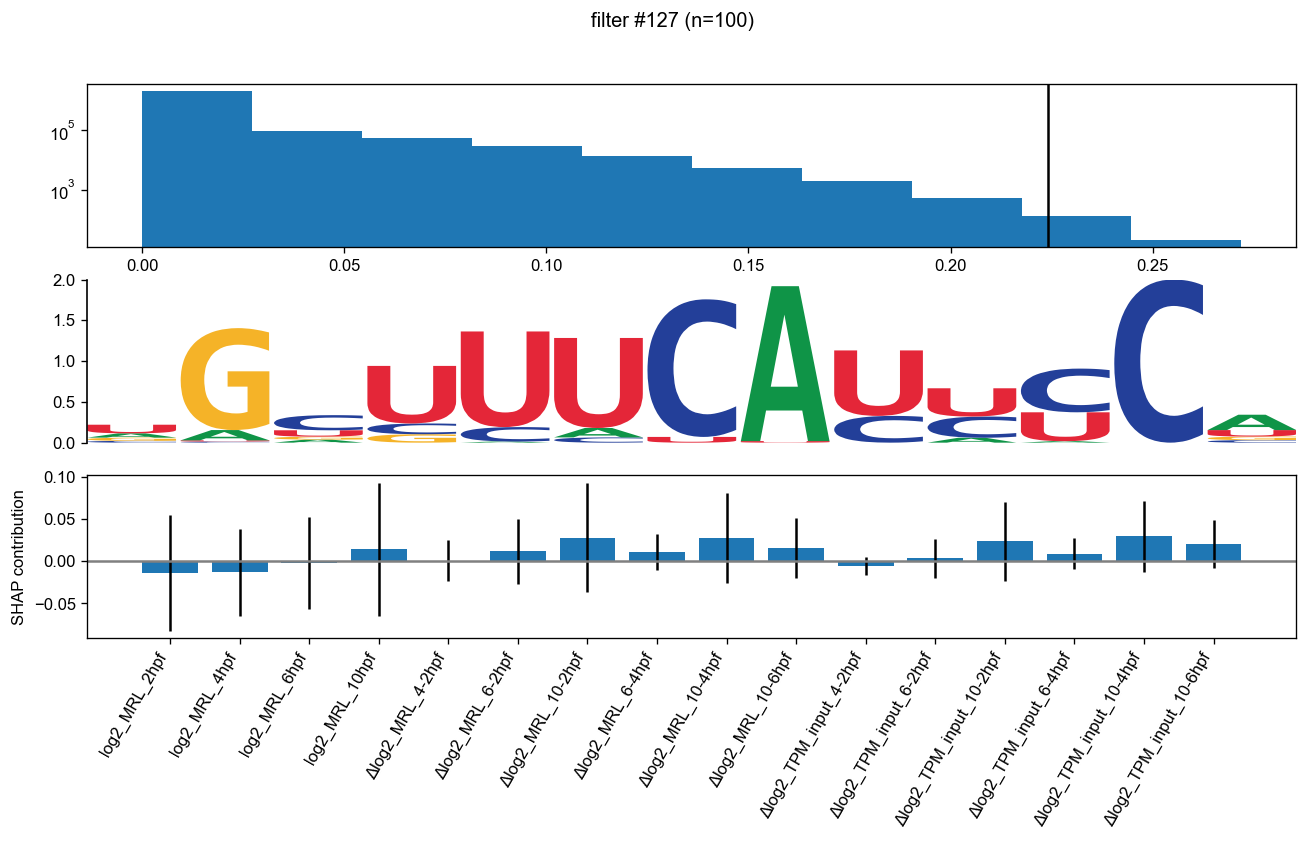

In [18]:
# Extract filters from each reduced model and generate plots
meme_all_str = meme_header

for model_idx in range(len(reduced_models)):
    print(f"Processing model {model_idx}...")

    model_plot_dir = os.path.join(filter_ext_dir, f'model_{model_idx}')
    if not os.path.exists(model_plot_dir):
        os.mkdir(model_plot_dir)

    # Get "scores" - output of the selected convolutional layer
    # dimensions are (n_sequences, sequence_length, n_filters)
    scores = reduced_models[model_idx].predict(seqs_one_hot)

    # Mask scores outside of sequence
    scores_masked = scores.copy()
    for i in range(len(data)):
        seq_len = data.iloc[i]['insert_length']
        scores_masked[i, :max_seq_len - seq_len + receptive_field//2, :] = -numpy.inf
        scores_masked[i, -receptive_field//2 + 1:, :] = -numpy.inf

    # Analyze each filter
    # Takes ~1 minute to run
    filters_pwm = []
    filters_n_seqlets = []

    n_filters = scores_masked.shape[-1]
    for filter_idx in range(n_filters):
        print(f"Filter {filter_idx} / {n_filters}...")

        # Get score threshold to filter for n_seqlets_per_filter to keep
        # "n_seqlets_per_filter" seqlets
        scores_filter = scores_masked[:, :, filter_idx]
        scores_filter_flat = scores_filter.reshape(-1)
        score_threshold = numpy.sort(scores_filter_flat)[-n_seqlets_per_filter]

        if score_threshold <= 0:
            pos_seqlets = []
            filter_pwm = 0.25*numpy.ones((receptive_field, 4))
            filter_seqlet_scores = numpy.zeros((0, len(res_cols)))
            filter_avg_shap = numpy.zeros(contributions_array.shape[1])
            n_seqlets = 0

        else:
            # Accumulate seqlets to obtain filter PWM

            # Get positions of seqlets
            # result is a tuple with two arrays:
            #   array with sequence index,
            #   array with seqlet center position within sequence

            coords_seqlets = numpy.nonzero(scores_filter >= score_threshold)
            
            # Change center position with start, end
            pos_seqlets = [
                [
                    seq_idx,
                    seqlet_center - receptive_field//2,
                    seqlet_center + receptive_field//2 + 1,
                ]
                for seq_idx, seqlet_center in zip(*coords_seqlets)
            ]

            # Accumulate seqlets and positions
            filter_seqlets = []
            # filter_seqlets_coords = []
            for seq_idx, seqlet_start, seqlet_end in pos_seqlets:
                # dimensions: 
                # input: seq_idx, position, channel
                # ouput: position, channel
                seqlet_onehot = seqs_one_hot[seq_idx, seqlet_start: seqlet_end, :]

                filter_seqlets.append(seqlet_onehot)
                # filter_seqlets_coords.append([seq_idx, start_pos, end_pos])

            filter_seqlets = numpy.array(filter_seqlets)
            n_seqlets = len(filter_seqlets)

            # Calculate PWM
            filter_pwm = numpy.mean(filter_seqlets, axis=0)

            # Get shap scores of all seqlets with contributions
            filter_shap_scores = []
            for seq_idx, seqlet_start, seqlet_end in pos_seqlets:
                
                # dimensions: 
                # input: seq_idx, position, channel
                # ouput: position, channel
                seqlet_onehot = seqs_one_hot[seq_idx, seqlet_start: seqlet_end, :]

                # dimensions:
                # input: seq_idx, output, position, channel
                # output: output, position, channel
                seqlet_shap = contributions_array[seq_idx, :, seqlet_start: seqlet_end, :]

                # multiply, sum across channel
                # final dim: outputs, positions
                seqlet_shap_collapsed = numpy.sum(seqlet_shap*numpy.expand_dims(seqlet_onehot, axis=0), axis=-1)

                filter_shap_scores.append(seqlet_shap_collapsed)

            # Get filter average contribution
            # sum across positions, average across sequences
            # dimensions:
            # input: seqlet_idx, outputs, positions
            # output: outputs
            filter_shap_scores = numpy.array(filter_shap_scores)
            filter_seqlet_scores = numpy.sum(filter_shap_scores, axis=-1)
            filter_avg_shap = numpy.mean(filter_seqlet_scores, axis=0)

            # Make filter plot

            # fig, axes = pyplot.subplots(3, 1, figsize=(receptive_field, 6))
            fig, axes = pyplot.subplots(3, 1, num=1, clear=True)
            fig.set_size_inches(receptive_field, 6)
            fig.suptitle(f'filter #{filter_idx} (n={n_seqlets:,})')

            # Histogram of seqlet scores
            ax = axes[0]
            
            # Histogram of scores of a filter
            scores_filter = scores_masked[:, :, filter_idx]
            scores_to_plot = scores_filter.reshape(-1)
            scores_to_plot = scores_to_plot[scores_to_plot!=-numpy.inf]
            ax.hist(scores_to_plot, log=True)
            ax.axvline(score_threshold, color='k')

            # Seqlet-based sequence logo
            ax = axes[1]
            custom_plots.plot_seq_logo(seq_val=filter_pwm, ax=ax)
            ax.set_ylim(0, 2)

            # Bar with seqlet scores
            ax = axes[2]
            
            # Make extended version of seqlet scores
            # MRL, then delta MRL, then delta input TPM
            filter_seqlet_scores_extended = make_extended_output(filter_seqlet_scores).T

            ax.bar(
                model_outputs_ext_labels,
                numpy.mean(filter_seqlet_scores_extended, axis=0),
                yerr=numpy.std(filter_seqlet_scores_extended, axis=0),
            )
            ax.set_ylabel('SHAP contribution')
            ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')
            # ax.set_ylim(-0.3, 0.3)
            # ax.grid(True)
            ax.axhline(0, color='grey')

            fig.savefig(
                os.path.join(model_plot_dir, f'filter_{filter_idx:03d}.png'),
                dpi=200,
                bbox_inches='tight',
            )
            # pyplot.close(fig)

        filters_pwm.append(filter_pwm)
        filters_n_seqlets.append(n_seqlets)

    # Save meme file
    print("Saving meme file...")
    meme_model_str = meme_header

    # Generate motif meme string
    for filter_idx in range(n_filters):
        
        filter_pwm = filters_pwm[filter_idx]
        n_seqlets = filters_n_seqlets[filter_idx]

        meme_motif_full_str = ''
        meme_motif_full_str += f'MOTIF model_{model_idx}_filter_{filter_idx:03d} model_{model_idx}_filter_{filter_idx:03d}\n'
        meme_motif_full_str += f'letter-probability matrix: alength= 4 w= {filter_pwm.shape[0]} nsites= {n_seqlets}\n'
        for pwm_row in filter_pwm:
            for pwm_val in pwm_row:
                meme_motif_full_str += f'{pwm_val:.6f} '
            meme_motif_full_str += '\n'

        # Add string to model meme file string and global meme file string
        meme_model_str += meme_motif_full_str + '\n'
        meme_all_str += meme_motif_full_str + '\n'

    # Save model meme file
    with open(os.path.join(model_plot_dir, 'motifs.meme'), 'w') as file: 
        file.write(meme_model_str)

    print(f"Done with model {model_idx}.")

# Save global meme file
with open(os.path.join(filter_ext_dir, 'motifs.meme'), 'w') as file: 
    file.write(meme_all_str)

# Step 2. Motif clustering

## Split motifs into AUG and non-AUG

In [19]:
# Load all motifs
motif_filepath = os.path.join(filter_ext_dir, 'motifs.meme')
motifs_dict = seq_utils.load_meme(motif_filepath)

(array([  1.,  12.,   0.,   2.,   2.,   2.,   6.,  28.,  16.,  26.,  25.,
         29.,  34.,  33.,  31.,  44.,  60.,  23.,  38.,  55.,  42.,  36.,
         44.,  37.,  49.,  42.,  28.,  48.,  63.,  24.,  16.,  19.,   6.,
         18.,  13.,   9.,   9.,   9.,   9.,   8.,   8.,  11.,  11.,   4.,
          8.,  19.,  16.,  14.,  31., 161.]),
 array([0.669903  , 0.71650494, 0.76310688, 0.80970882, 0.85631076,
        0.9029127 , 0.94951464, 0.99611658, 1.04271852, 1.08932046,
        1.1359224 , 1.18252434, 1.22912628, 1.27572822, 1.32233016,
        1.3689321 , 1.41553404, 1.46213598, 1.50873792, 1.55533986,
        1.6019418 , 1.64854374, 1.69514568, 1.74174762, 1.78834956,
        1.8349515 , 1.88155344, 1.92815538, 1.97475732, 2.02135926,
        2.0679612 , 2.11456314, 2.16116508, 2.20776702, 2.25436896,
        2.3009709 , 2.34757284, 2.39417478, 2.44077672, 2.48737866,
        2.5339806 , 2.58058254, 2.62718448, 2.67378642, 2.72038836,
        2.7669903 , 2.81359224, 2.86019418, 2.

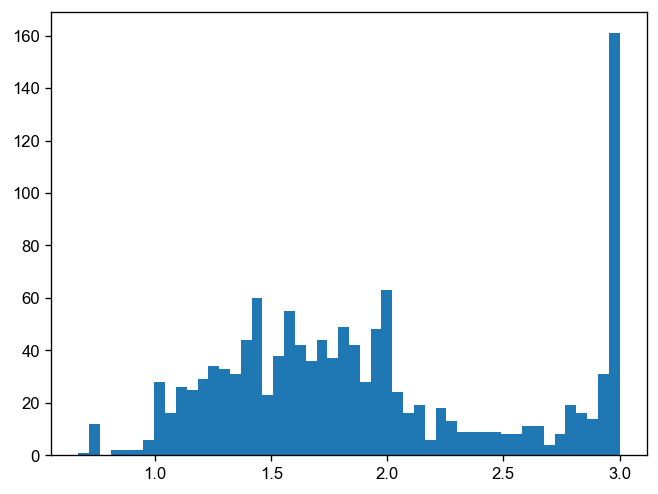

In [20]:
# Visualize ATG likelihood scores for all motifs
# Score for one motif is the max score across all possible alignments
aug_scores = []
motif_to_check = 'ATG'
motif_to_check_onehot = seq_utils.one_hot_encode([motif_to_check])[0]

for motif_id, motif_info in motifs_dict.items():
    score = -numpy.inf

    motif_ppm = motif_info['ppm']
    for i in range(len(motif_ppm) - len(motif_to_check) + 1):
        score_i = numpy.sum(motif_ppm[i:i+len(motif_to_check)] * motif_to_check_onehot)
        if score_i > score:
            score = score_i
    
    aug_scores.append(score)
    
fig, ax = pyplot.subplots()
ax.hist(aug_scores, bins=50)

In [21]:
# Actually separate by score
# Per base likelihood score threshold: 2.5 / 3 = 0.833
aug_score_thresh = 2.5
motif_to_check = 'ATG'
motif_to_check_onehot = seq_utils.one_hot_encode([motif_to_check])[0]

motifs_aug_dict = {}
motifs_nonaug_dict = {}

for motif_id, motif_info in motifs_dict.items():
    score = -numpy.inf

    motif_ppm = motif_info['ppm']
    for i in range(len(motif_ppm) - len(motif_to_check) + 1):
        score_i = numpy.sum(motif_ppm[i:i+len(motif_to_check)] * motif_to_check_onehot)
        if score_i > score:
            score = score_i
    
    if score >= aug_score_thresh:
        motifs_aug_dict[motif_id] = motif_info
    else:
        motifs_nonaug_dict[motif_id] = motif_info
    
# Save motifs
save_meme_from_dict(motifs_aug_dict, os.path.join(analysis_dir, 'motifs_aug.meme'))
save_meme_from_dict(motifs_nonaug_dict, os.path.join(analysis_dir, 'motifs_nonaug.meme'))

## Cluster motifs

### Install matrix clustering

Install the repo from ```https://github.com/jaimicore/matrix-clustering_stand-alone```

Change line 184 of ```compare-matrices-quick/compare-matrices-quick.c``` to always choose the non-reversed motif (```best_correl = 0```)

OR

Install repo from ```https://github.com/castillohair/matrix-clustering_stand-alone```

Follow the repo installation instructions.

### Prepare files for clustering

Make directory `data` inside the `matrix-clustering` directory. Make a `zb_motif_clustering` directory inside.

Copy files `motifs_aug.meme` and `motifs_nonaug.meme` from the directory given by `analysis_dir` to `data/zb_motif_clustering`

Create file `motif_aug_table.txt` inside this directory with the following contents:

```
data/zb_motif_clustering/motifs_aug.meme	abcd	meme
```

Similarly, create file `motif_nonaug_table.txt` with the following contents:

```
data/zb_motif_clustering/motifs_nonaug.meme	abcd	meme
```

### Run clustering

Run the following commands from the matrix-clustering directory:

```Rscript matrix-clustering.R -i data/zb_motif_clustering/motif_aug_table.txt -o data/zb_motif_clustering/clustering_aug/motif_analysis -w 8 --export_heatmap TRUE --cor_th 0.0 --Ncor_th 0.55 --w_th 4 --linkage_method average```

```Rscript matrix-clustering.R -i data/zb_motif_clustering/motif_nonaug_table.txt -o data/zb_motif_clustering/clustering_nonaug/motif_analysis -w 8 --export_heatmap TRUE --cor_th 0.0 --Ncor_th 0.6 --w_th 4 --linkage_method average```

Copy directories `clustering_aug` and `clustering_nonaug` to the directory given by `analysis_dir`.

### Examine motif clusters

Here we look at some metrics of the motif clusters.

In [22]:
# cluster_dir = os.path.join(analysis_dir, 'clustering_aug')
cluster_dir = os.path.join(analysis_dir, 'clustering_nonaug')

In [23]:
# Read cluster to motif assignment
cluster_df = pandas.read_csv(os.path.join(cluster_dir, 'motif_analysis_tables/clusters.tab'), sep='\t', index_col='cluster')
display(cluster_df)

# Read aligned motifs
with open(os.path.join(cluster_dir, 'motif_analysis_motifs/root_motifs/Root_motifs.tf'), 'r') as f:
    cluster_root_motifs = Bio.motifs.transfac.read(f, strict=False)

cluster_root_motifs_dict = {}
for motif in cluster_root_motifs:
    cluster_root_motifs_dict[motif['ID']] = motif
display(cluster_root_motifs_dict)


,id,name
cluster,,
cluster_001,"abcd_model_3_filter_019_n313,abcd_model_0_filt...","model_3_filter_019,model_0_filter_043,model_7_..."
cluster_002,"abcd_model_4_filter_048_n429,abcd_model_1_filt...","model_4_filter_048,model_1_filter_012,model_4_..."
cluster_003,"abcd_model_1_filter_052_n135,abcd_model_0_filt...","model_1_filter_052,model_0_filter_106,model_7_..."
cluster_004,"abcd_model_8_filter_043_n817,abcd_model_1_filt...","model_8_filter_043,model_1_filter_083,model_2_..."
cluster_005,"abcd_model_8_filter_072_n839,abcd_model_3_filt...","model_8_filter_072,model_3_filter_068,model_9_..."
...,...,...
cluster_569,abcd_model_9_filter_116_n972,model_9_filter_116
cluster_570,abcd_model_9_filter_119_n975,model_9_filter_119
cluster_571,abcd_model_9_filter_120_n976,model_9_filter_120


{'cluster_001': {'AC': 'cluster_001', 'ID': 'cluster_001'},
 'cluster_002': {'AC': 'cluster_002', 'ID': 'cluster_002'},
 'cluster_003': {'AC': 'cluster_003', 'ID': 'cluster_003'},
 'cluster_004': {'AC': 'cluster_004', 'ID': 'cluster_004'},
 'cluster_005': {'AC': 'cluster_005', 'ID': 'cluster_005'},
 'cluster_006': {'AC': 'cluster_006', 'ID': 'cluster_006'},
 'cluster_007': {'AC': 'cluster_007', 'ID': 'cluster_007'},
 'cluster_008': {'AC': 'cluster_008', 'ID': 'cluster_008'},
 'cluster_009': {'AC': 'cluster_009', 'ID': 'cluster_009'},
 'cluster_010': {'AC': 'cluster_010', 'ID': 'cluster_010'},
 'cluster_011': {'AC': 'cluster_011', 'ID': 'cluster_011'},
 'cluster_012': {'AC': 'cluster_012', 'ID': 'cluster_012'},
 'cluster_013': {'AC': 'cluster_013', 'ID': 'cluster_013'},
 'cluster_014': {'AC': 'cluster_014', 'ID': 'cluster_014'},
 'cluster_015': {'AC': 'cluster_015', 'ID': 'cluster_015'},
 'cluster_016': {'AC': 'cluster_016', 'ID': 'cluster_016'},
 'cluster_017': {'AC': 'cluster_017', 'I

In [24]:
# Count number of models in each cluster
filter_name_pattern = re.compile(f'^model_(\d+)_filter_(\d+)$')
def parse_filter_info(filter_name):
    filter_info = filter_name_pattern.findall(filter_name)[0]
    model_idx = int(filter_info[0])
    filter_idx = int(filter_info[1])
    return model_idx, filter_idx

for index, row in cluster_df.iterrows():
    motif_names = row['name'].split(',')
    model_ids = []
    for motif_name in motif_names:
        model_idx, filter_idx = parse_filter_info(motif_name)
        model_ids.append(model_idx)
    model_ids = list(set(model_ids))
    cluster_df.loc[index, 'n_filters'] = len(motif_names)
    cluster_df.loc[index, 'n_models'] = len(model_ids)

cluster_df

,id,name,n_filters,n_models
cluster,,,,
cluster_001,"abcd_model_3_filter_019_n313,abcd_model_0_filt...","model_3_filter_019,model_0_filter_043,model_7_...",3.0,3.0
cluster_002,"abcd_model_4_filter_048_n429,abcd_model_1_filt...","model_4_filter_048,model_1_filter_012,model_4_...",26.0,10.0
cluster_003,"abcd_model_1_filter_052_n135,abcd_model_0_filt...","model_1_filter_052,model_0_filter_106,model_7_...",6.0,6.0
cluster_004,"abcd_model_8_filter_043_n817,abcd_model_1_filt...","model_8_filter_043,model_1_filter_083,model_2_...",3.0,3.0
cluster_005,"abcd_model_8_filter_072_n839,abcd_model_3_filt...","model_8_filter_072,model_3_filter_068,model_9_...",11.0,6.0
...,...,...,...,...
cluster_569,abcd_model_9_filter_116_n972,model_9_filter_116,1.0,1.0
cluster_570,abcd_model_9_filter_119_n975,model_9_filter_119,1.0,1.0
cluster_571,abcd_model_9_filter_120_n976,model_9_filter_120,1.0,1.0


Text(0, 0.5, 'frequency')

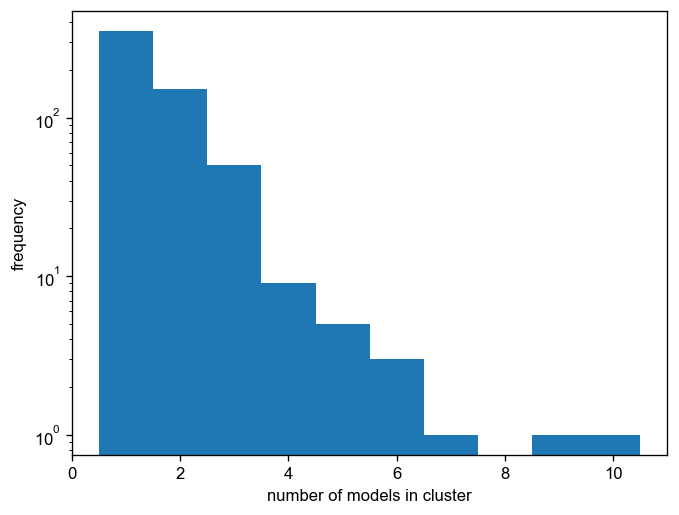

In [25]:
fig, ax = pyplot.subplots()
bins = numpy.arange(cluster_df['n_models'].max() + 1) + 0.5
ax.hist(cluster_df['n_models'], bins=bins, log=True)
ax.set_xlabel('number of models in cluster')
ax.set_ylabel('frequency')

In [26]:
# Select reocurring motifs
cluster_hc_df = cluster_df[cluster_df['n_models'] >= 5]
cluster_hc_df = cluster_hc_df.sort_values('n_models', ascending=False)
display(cluster_hc_df)
print(len(cluster_hc_df))
print(cluster_hc_df['n_filters'].sum())
print(cluster_df['n_filters'].sum())

,id,name,n_filters,n_models
cluster,,,,
cluster_002,"abcd_model_4_filter_048_n429,abcd_model_1_filt...","model_4_filter_048,model_1_filter_012,model_4_...",26.0,10.0
cluster_016,"abcd_model_8_filter_061_n833,abcd_model_1_filt...","model_8_filter_061,model_1_filter_096,model_9_...",16.0,9.0
cluster_013,"abcd_model_8_filter_101_n856,abcd_model_1_filt...","model_8_filter_101,model_1_filter_077,model_4_...",9.0,7.0
cluster_003,"abcd_model_1_filter_052_n135,abcd_model_0_filt...","model_1_filter_052,model_0_filter_106,model_7_...",6.0,6.0
cluster_005,"abcd_model_8_filter_072_n839,abcd_model_3_filt...","model_8_filter_072,model_3_filter_068,model_9_...",11.0,6.0
cluster_007,"abcd_model_1_filter_001_n94,abcd_model_5_filte...","model_1_filter_001,model_5_filter_051,model_7_...",6.0,6.0
cluster_011,"abcd_model_5_filter_084_n557,abcd_model_7_filt...","model_5_filter_084,model_7_filter_013,model_9_...",6.0,5.0
cluster_015,"abcd_model_3_filter_074_n356,abcd_model_5_filt...","model_3_filter_074,model_5_filter_031,model_8_...",5.0,5.0
cluster_023,"abcd_model_1_filter_011_n102,abcd_model_7_filt...","model_1_filter_011,model_7_filter_118,model_0_...",5.0,5.0


11
101.0
980.0


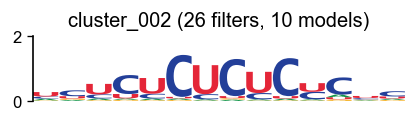

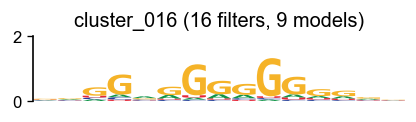

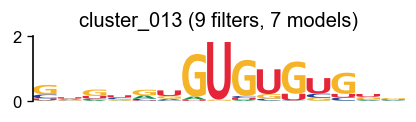

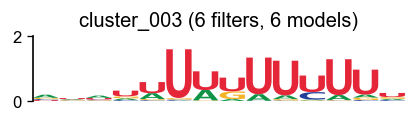

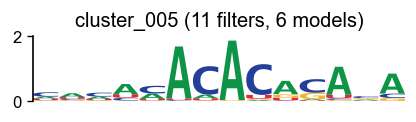

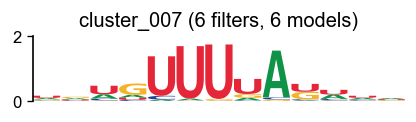

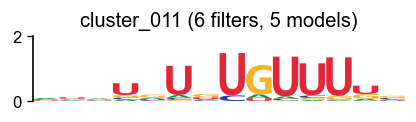

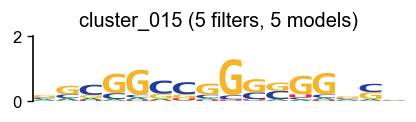

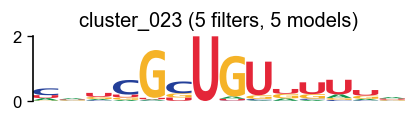

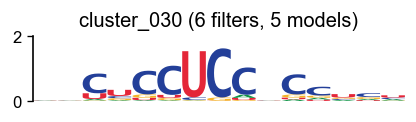

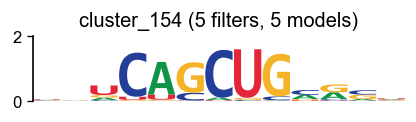

In [27]:
# Plot pwms of each high confidence motif
for cluster_id, row in cluster_hc_df.iterrows():
    cluster_root_motif = cluster_root_motifs_dict[cluster_id]

    # Extract pwm values
    pwm = numpy.array(list(cluster_root_motif.pwm.values())).T

    # Plot
    fig, ax = pyplot.subplots(figsize=(4, 0.7))
    custom_plots.plot_seq_logo(seq_val=pwm, ax=ax)
    ax.set_title(f"{cluster_id} ({int(row['n_filters'])} filters, {int(row['n_models'])} models)")
    ax.set_ylim(0, 2)
    # fig.savefig(
    #     os.path.join(cluster_dir, f'{cluster_id}.png'),
    #     dpi=200,
    #     bbox_inches='tight',
    # )

# Step 3. Filter and combine motifs
Here, we filter each motif cluster based on how many models their member motifs come from. We combine selected clusters from the AUG and nonAUG set, trim their PWMs, and save them to `{analysis_dir}/clustering_merged/motifs.meme`. This is the final list of motifs.

In [30]:
# Directory where to store filtered and combined motifs and related plots
cluster_output_dir = os.path.join(analysis_dir, 'clustering_merged')
if not os.path.exists(cluster_output_dir):
    os.mkdir(cluster_output_dir)

In [31]:
# Filter settings
# Directory source of motif clusters, number of models to filter each motif by, and the name prefix to use in the motif names.
clusters_info = [
    {
        'path': os.path.join(analysis_dir, 'clustering_aug'),
        'n_model_threshold': 10,
        'prefix': 'aug',
    },
    {
        'path': os.path.join(analysis_dir, 'clustering_nonaug'),
        'n_model_threshold': 5,
        'prefix': 'nonaug',
    },
]

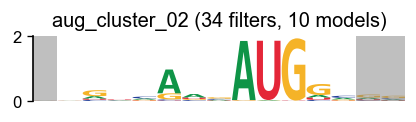

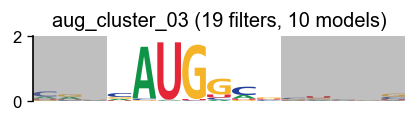

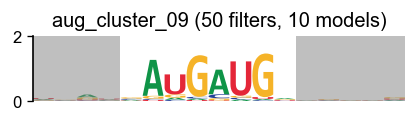

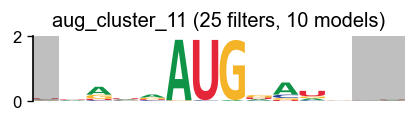

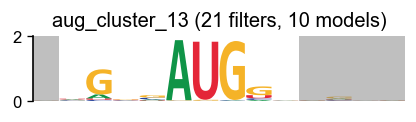

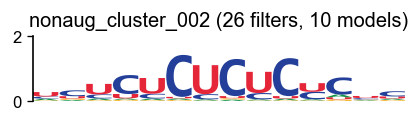

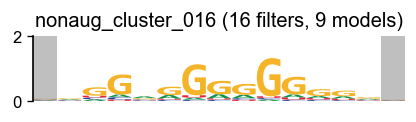

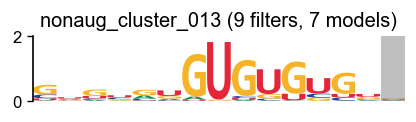

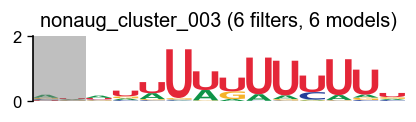

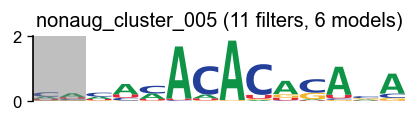

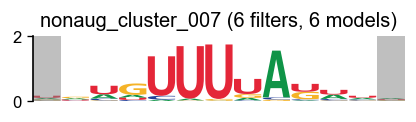

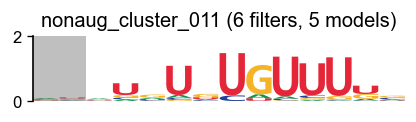

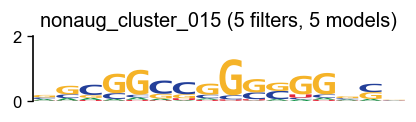

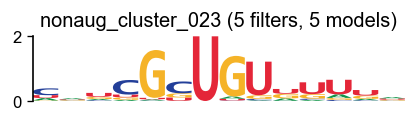

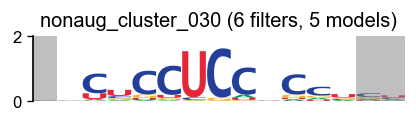

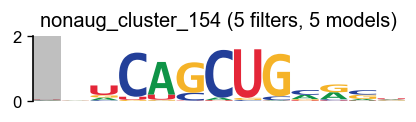

In [33]:
# Filter and combine motifs

meme_full_str = meme_header

motif_clusters_df = pandas.DataFrame()
motif_clusters_pwms = {}

for cluster_info in clusters_info:

    # Read cluster to motif assignment
    cluster_dir = cluster_info['path']
    cluster_df = pandas.read_csv(os.path.join(cluster_dir, 'motif_analysis_tables/clusters.tab'), sep='\t', index_col='cluster')
    cluster_df.index = [f"{cluster_info['prefix']}_{s}" for s in cluster_df.index]

    # Read aligned motifs
    with open(os.path.join(cluster_dir, 'motif_analysis_motifs/root_motifs/Root_motifs.tf'), 'r') as f:
        cluster_root_motifs = Bio.motifs.transfac.read(f, strict=False)

    cluster_root_motifs_dict = {}
    for motif in cluster_root_motifs:
        cluster_root_motifs_dict[f"{cluster_info['prefix']}_{motif['ID']}"] = motif

    # Count number of models in each cluster
    for index, row in cluster_df.iterrows():
        motif_names = row['name'].split(',')
        model_ids = []
        for motif_name in motif_names:
            model_idx, filter_idx = parse_filter_info(motif_name)
            model_ids.append(model_idx)
        model_ids = list(set(model_ids))
        cluster_df.loc[index, 'n_filters'] = len(motif_names)
        cluster_df.loc[index, 'n_models'] = len(model_ids)

    # Apply threshold on number of models
    cluster_hc_df = cluster_df[cluster_df['n_models'] >= cluster_info['n_model_threshold']]
    cluster_hc_df = cluster_hc_df.sort_values('n_models', ascending=False)

    motif_clusters_df = pandas.concat(
        (
            motif_clusters_df,
            cluster_hc_df,
        ),
        axis=0,
    )

    # Trim PWMs, add to meme file, and plot
    for cluster_id, row in cluster_hc_df.iterrows():
        cluster_root_motif = cluster_root_motifs_dict[cluster_id]

        # Extract pwm values
        pwm = numpy.array(list(cluster_root_motif.pwm.values())).T

        # Trim
        bg = numpy.array([0.25, 0.25, 0.25, 0.25])
        pseudocount = 0.001
        cluster_ic_per_pos = numpy.log2((pwm + pseudocount) / (1 + pseudocount*len(bg)))*pwm - (numpy.log2(bg)*bg)[None, :]
        cluster_ic_per_pos = numpy.sum(cluster_ic_per_pos, axis=1)
        cluster_ic = pwm*cluster_ic_per_pos[:, None]
        
        motif_ic_cutoff = 0.3
        high_info_indices = numpy.nonzero(numpy.sum(cluster_ic, axis=1) > motif_ic_cutoff)
        motif_start = max(0, high_info_indices[0][0] - 1)
        motif_end = min(len(pwm), high_info_indices[0][-1] + 1 + 1)

        pwm_trimmed = pwm[motif_start: motif_end]
        motif_clusters_pwms[cluster_id] = pwm_trimmed

        # Add to meme file
        meme_motif_full_str = ''
        meme_motif_full_str += f"MOTIF {cluster_id} {cluster_id}\n"
        meme_motif_full_str += f'letter-probability matrix: alength= 4 w= {pwm_trimmed.shape[0]}\n'
        for pwm_row in pwm_trimmed:
            for pwm_val in pwm_row:
                meme_motif_full_str += f'{pwm_val:.6f} '
            meme_motif_full_str += '\n'
        meme_full_str += meme_motif_full_str + '\n'

        # Plot
        fig, ax = pyplot.subplots(figsize=(4, 0.7))

        custom_plots.plot_seq_logo(seq_val=pwm, ax=ax)
        ax.axvspan(-1, motif_start - 0.5, facecolor='gray', alpha=0.5)
        ax.axvspan(motif_end - 0.5, pwm.shape[0] + 1, facecolor='gray', alpha=0.5)

        ax.set_title(f"{cluster_id} ({int(row['n_filters'])} filters, {int(row['n_models'])} models)")
        ax.set_ylim(0, 2)

        fig.savefig(
            os.path.join(cluster_output_dir, f'filtered_trimmed_{cluster_id}.png'),
            dpi=200,
            bbox_inches='tight',
        )
    
# Save meme file
with open(os.path.join(cluster_output_dir, 'motifs.meme'), 'w') as file: 
    file.write(meme_full_str)

# Step 4. Calculate motif contributions

Here we will align motif clusters using FIMO and derive a motif contribution score from the contributions within the aligned seqlets. Finally, we will make contribution heatmap plots of all selected motif clusters.

In [29]:
# Export all MPRA sequences to fasta to use with FIMO
seq_records = []

# Iterate over DataFrame rows and create SeqRecord objects
for insert_idx, (index, row) in enumerate(data.iterrows()):
    sequence = row['insert_seq']
    record = SeqRecord(Seq(sequence), id=str(insert_idx), description='')
    seq_records.append(record)

# Specify the output file name
output_file = os.path.join(cluster_output_dir, '5utr_sequences.fasta')

# Write SeqRecord objects to the output file in FASTA format
with open(output_file, 'w') as f:
    SeqIO.write(seq_records, f, 'fasta')

Uploaded `5utr_sequences.fasta` and `motifs.meme` from the `clustering_merged` directory to the FIMO website. Scanned with options match pvalue < 1e-4, given strand only, background model from motif file, don't parse genomic coordinates. Copy `fimo.tsv` to `{analysis_dir}/clustering_merged`.

In [34]:
# Load motif scan results
motif_scan_df = pandas.read_csv(os.path.join(cluster_output_dir, 'fimo.tsv'), sep='\t', skipfooter=4)
# Recover original sequence name
motif_scan_df['sequence_name'] = data.iloc[motif_scan_df['sequence_name']].index.values

motif_scan_df

C:\Users\casti\AppData\Local\Temp\ipykernel_33936\1567644200.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  motif_scan_df = pandas.read_csv(os.path.join(cluster_output_dir, 'fimo.tsv'), sep='\t', skipfooter=4)


,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,nonaug_cluster_013,nonaug_cluster_013,ENSDARG00000025576_ENSDART00000137736_14086_mk...,1,14,+,18.62,3.730000e-09,0.000022,GTGTGTGTGTGTGT
1,nonaug_cluster_013,nonaug_cluster_013,ENSDARG00000074229_ENSDART00000110514_2569_prr...,1,14,+,18.62,3.730000e-09,0.000022,GTGTGTGTGTGTGT
2,nonaug_cluster_013,nonaug_cluster_013,ENSDARG00000039669_ENSDART00000057986_9249_TST...,9,22,+,18.62,3.730000e-09,0.000022,GTGTGTGTGTGTGT
3,nonaug_cluster_013,nonaug_cluster_013,ENSDARG00000074634_ENSDART00000148911_16182_ke...,11,24,+,18.62,3.730000e-09,0.000022,GTGTGTGTGTGTGT
4,nonaug_cluster_013,nonaug_cluster_013,ENSDARG00000008573_ENSDART00000152357_9367_fam...,12,25,+,18.62,3.730000e-09,0.000022,GTGTGTGTGTGTGT
...,...,...,...,...,...,...,...,...,...,...
17102,nonaug_cluster_013,nonaug_cluster_013,ENSDARG00000067723_ENSDART00000148918_19154_ta...,67,80,+,10.45,9.990000e-05,0.078000,AAGTGTGTGCGTGT
17103,nonaug_cluster_013,nonaug_cluster_013,ENSDARG00000067723_ENSDART00000148918_19154_ta...,80,93,+,10.45,9.990000e-05,0.078000,AAGTGTGTGCGTGT
17104,nonaug_cluster_013,nonaug_cluster_013,ENSDARG00000099954_ENSDART00000159986_2206_ple...,107,120,+,10.45,9.990000e-05,0.078000,AGGCATGTGTGTGA
17105,nonaug_cluster_013,nonaug_cluster_013,ENSDARG00000070162_ENSDART00000139354_658_stox...,122,135,+,10.45,9.990000e-05,0.078000,TCGGCTGTGTGTGC


In [36]:
# Get contributions for each motif cluster

motif_clusters_scores_dict = {}

for motif_cluster_id in motif_clusters_df.index:
    motif_cluster_scan_df = motif_scan_df[motif_scan_df['motif_id']==motif_cluster_id]

    motif_scores = []

    for index, motif_alignment in motif_cluster_scan_df.iterrows():
        # Get match coordinates and verify that the sequence matches.
        seq_id = motif_alignment['sequence_name']
        seq = data.loc[seq_id, 'insert_seq']
        start_pos = motif_alignment['start'] - 1
        end_pos = motif_alignment['stop']
        assert(motif_alignment['matched_sequence']==seq[start_pos:end_pos])
        
        # Get contributions across the motif match region
        seq_onehot = seq_utils.one_hot_encode(
            [seq],
            max_seq_len=max_seq_len, padding='right', mask_val=0,
        )

        contributions_seq = contributions_dict[seq_id]
        projected_exp = numpy.array([
            numpy.sum(contributions_seq[model_output_idx][None,:,:]*seq_onehot, axis=-1)[0]
            for model_output_idx in range(len(res_cols))
        ])

        coord_offset = max_seq_len - len(seq)
        match_score = numpy.sum(projected_exp[:, start_pos + coord_offset: end_pos + coord_offset], axis=1)


        motif_scores.append(match_score)

    motif_scores = numpy.array(motif_scores)

    motif_clusters_scores_dict[motif_cluster_id] = motif_scores


In [37]:
# Code to extent outputs to include MRL differences with respect to the initial timepoint
def make_extended_output(val):
    val_extended = numpy.array([
            val[:, 0],
            val[:, 1],
            val[:, 2],
            val[:, 3],
            val[:, 1] - val[:, 0],
            val[:, 2] - val[:, 0],
            val[:, 3] - val[:, 0],
            val[:, 4],
            val[:, 5],
            val[:, 6],
        ])
    return val_extended

model_outputs_ext_labels = [
    'log2_MRL_2hpf',
    'log2_MRL_4hpf',
    'log2_MRL_6hpf',
    'log2_MRL_10hpf',
    'Δlog2_MRL_4-2hpf',
    'Δlog2_MRL_6-2hpf',
    'Δlog2_MRL_10-2hpf',
    'Δlog2_TPM_input_4-2hpf',
    'Δlog2_TPM_input_6-2hpf',
    'Δlog2_TPM_input_10-2hpf',
]

In [37]:
# Plot contribution heatmaps for each motif cluster
# Make one plot for each extended output, where motif clusters are sorted by their contribution value on that output.

# Calculate average motif contribution score across seqlets for all extended outputs
avg_contrib_scores = []
for motif_cluster_id in motif_clusters_df.index:
    pwm = motif_clusters_pwms[motif_cluster_id]
    contrib_scores = motif_clusters_scores_dict[motif_cluster_id]
    avg_contrib_scores.append(numpy.mean(contrib_scores, axis=0))
avg_contrib_scores = numpy.array(avg_contrib_scores)

avg_contrib_scores_ext = make_extended_output(avg_contrib_scores).T
avg_contrib_scores_ext_df = pandas.DataFrame(avg_contrib_scores_ext, index=motif_clusters_df.index, columns=model_outputs_ext_labels)

# Get max motif length for plotting
max_pwm_len = 0
for k, pwm in motif_clusters_pwms.items():
    max_pwm_len = max(max_pwm_len, len(pwm))

# Iterate over extended outputs, make one plot for each
for model_output in model_outputs_ext_labels:
    print(f"Generating global plot for model output {model_output}...")
    df_to_plot = avg_contrib_scores_ext_df.sort_values(model_output, ascending=False)

    # Initialize plot
    gs_kw = dict(width_ratios=[0.25, 1], height_ratios=[1]*df_to_plot.shape[0])
    fig, axd = pyplot.subplot_mosaic(
        [[cluster_id, 'heatmap'] for cluster_id, row in df_to_plot.iterrows()],
        gridspec_kw=gs_kw,
        num=1,
        clear=True,
    )
    fig.set_size_inches(df_to_plot.shape[1]*0.5, df_to_plot.shape[0]*0.2)
    fig.subplots_adjust(wspace=0.05)

    # Plot heatmap with contributions
    ax = axd['heatmap']
    seaborn.heatmap(
        df_to_plot,
        center=0,
        yticklabels=False,
        cmap='PuOr_r',
        cbar_kws={'fraction': 0.05, 'label': 'Mean motif contribution'},
        ax=ax,
    )
    ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')
    ax.set_ylabel('')

    # Plot motif cluster logos
    for cluster_id, row in df_to_plot.iterrows():
        ax = axd[cluster_id]
        ax.set_xticks([])
        ax.set_yticks([])

        cluster_pwm = motif_clusters_pwms[cluster_id]
        custom_plots.plot_seq_logo(seq_val=cluster_pwm, ax=ax, spines=False)
        ax.spines.bottom.set_visible(False)
        ax.set_ylim(0, 2)
        # Adjust xlim based on pwm length
        xlim = ax.get_xlim()
        ax.set_xlim(xlim[0] - max_pwm_len + len(cluster_pwm), xlim[1])
        ax.set_ylabel(cluster_id, rotation=0, va='center', ha='right')

    fig.savefig(
        os.path.join(cluster_output_dir, f'all_sorted_by_{model_output}.svg'),
        dpi=200,
        bbox_inches='tight',
    )
    # fig.savefig(
    #     os.path.join(cluster_output_dir, f'all_sorted_by_{model_output}.png'),
    #     dpi=200,
    #     bbox_inches='tight',
    # )

pyplot.close(fig)

Generating global plot for model output log2_MRL_2hpf...
Generating global plot for model output log2_MRL_4hpf...
Generating global plot for model output log2_MRL_6hpf...
Generating global plot for model output log2_MRL_10hpf...
Generating global plot for model output Δlog2_MRL_4-2hpf...
Generating global plot for model output Δlog2_MRL_6-2hpf...
Generating global plot for model output Δlog2_MRL_10-2hpf...
Generating global plot for model output Δlog2_TPM_input_4-2hpf...
Generating global plot for model output Δlog2_TPM_input_6-2hpf...
Generating global plot for model output Δlog2_TPM_input_10-2hpf...
